<a href="https://colab.research.google.com/github/Nikhil5566/Data-Science-Portfolio-Projects/blob/main/Irish%20Rent%20Prices%202020%202025%20(RTB%20Official%20Data).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Irish Rent Prices 2020-2025 (RTB Official Data)

# Introduction and key Insights

---

We started with a rich collection of official data from 2020 to 2025, meticulously compiled from irish_rent_specific.csv, irish_rent_by_county.csv, and irish_rent_full.csv. After combining these files, we ensured data quality by dropping a significant number of duplicate entries and handling missing values, especially those arising from our feature engineering steps.

Our initial data inspection revealed key columns like rent_euro, year, county, property_type, and bedrooms, which became central to our analysis. We then embarked on a series of statistical tests to uncover the market's dynamics:

First, we confirmed the undeniable 'Dublin Premium'. With an average rent of €1,831, Dublin stands out sharply against the rest of the country, where the average is €1,023. This difference isn't just noticeable; it's statistically highly significant, meaning it's highly unlikely to be due to random chance. Furthermore, our analysis showed that this gap is actually widening over time, indicating that rents in Dublin are increasing at a faster rate than in other regions.

Secondly, the ANOVA test decisively proved that location is a primary driver of rent prices. When comparing the top counties, we found significant differences in average rents, confirming that each county operates as a distinct market. A 'tier list' of counties based on median rent clearly illustrated this hierarchy, with Dublin leading the pack.

Our feature engineering efforts focused on creating 'memory' features, like Rent_Lag_1 (previous quarter's rent) and Rent_Rolling_Mean_4 (annual average rent), along with Rent_Velocity (rate of change). The Random Forest Feature Importance confirmed that these historical trends are paramount. The Rent_Rolling_Mean_4 emerged as the most crucial predictor, highlighting that the smoothed, long-term average rent trend is the strongest indicator of current prices.

Finally, we built a Gradient Boosting Regressor model to predict rent prices. The model performed exceptionally well, achieving an impressive 99.4% R2 accuracy and a remarkably low average prediction error of just €23.38. This translates to an error margin of only 1.6%, which is outstanding for real-world predictions. Visualizations comparing the model's predictions to actual market prices showed a near-perfect alignment, indicating that our model is highly reliable for forecasting Irish rent prices based on the data and features we’ve developed.

In essence, the Irish rental market is heavily influenced by location, with Dublin commanding a significant and growing premium. Past rental trends are highly predictive of future prices, and our machine learning model has successfully captured these complex relationships to provide accurate forecasts.

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Installing Kaggle API
!pip install -q kaggle

# Uploading kaggle.json
from google.colab import files
files.upload()

# Moving kaggle.json to ~/.kaggle/
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Downloading the dataset using Kaggle API
!kaggle datasets download -d adamvakar/irish-rent-prices-2020-2025-rtb-official-data

# Unziping the downloaded file
!unzip irish-rent-prices-2020-2025-rtb-official-data.zip

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/adamvakar/irish-rent-prices-2020-2025-rtb-official-data
License(s): DbCL-1.0
  0% 0.00/947k [00:00<?, ?B/s]
100% 947k/947k [00:00<00:00, 1.17GB/s]
Archive:  irish-rent-prices-2020-2025-rtb-official-data.zip
  inflating: irish_rent_by_county.csv  
  inflating: irish_rent_full.csv     
  inflating: irish_rent_specific.csv  


# Data Inspection

In [26]:
df = pd.concat(map(pd.read_csv, ['irish_rent_specific.csv','irish_rent_by_county.csv','irish_rent_full.csv']))
df.head(11)

,rent_euro,year,half,half_year,time_period,county,province,area,location,property_type,bedrooms,bedrooms_num,is_dublin,is_city,is_county_aggregate
0,751.44,2020,1,2020H1,1,Cork,Munster,Cork,Cork,Detached house,One bed,1.0,False,False,True
1,1311.22,2020,1,2020H1,1,Dublin,Leinster,Dublin,Dublin,Detached house,One bed,1.0,True,True,True
2,790.15,2020,1,2020H1,1,Galway,Connacht,Galway,Galway,Detached house,One bed,1.0,False,False,True
3,850.80,2020,1,2020H1,1,Meath,Leinster,Meath,Meath,Detached house,One bed,1.0,False,False,True
4,712.77,2020,1,2020H1,1,Cork,Munster,Cork,Cork,Semi detached house,One bed,1.0,False,False,True
5,1163.78,2020,1,2020H1,1,Dublin,Leinster,Dublin,Dublin,Semi detached house,One bed,1.0,True,True,True
6,887.90,2020,1,2020H1,1,Cork,Munster,Cork,Cork,Terrace house,One bed,1.0,False,False,True
7,930.82,2020,1,2020H1,1,Cork,Munster,Cork City,Cork City,Terrace house,One bed,1.0,False,True,False
8,1242.84,2020,1,2020H1,1,Dublin,Leinster,Dublin,Dublin,Terrace house,One bed,1.0,True,True,True
9,1225.45,2020,1,2020H1,1,Dublin,Leinster,Dublin 6,Dublin 6,Terrace house,One bed,1.0,True,True,False


In [27]:
df.tail(11)

,rent_euro,year,half,half_year,time_period,county,province,area,location,property_type,bedrooms,bedrooms_num,is_dublin,is_city,is_county_aggregate
50197,2325.23,2025,1,2025H1,11,Wicklow,Leinster,Wicklow,Wicklow,Semi detached house,Four plus bed,4.0,False,False,True
50198,2254.05,2025,1,2025H1,11,Cork,Munster,Cork,Cork,Terrace house,Four plus bed,4.0,False,False,True
50199,2563.44,2025,1,2025H1,11,Cork,Munster,Cork City,Cork City,Terrace house,Four plus bed,4.0,False,True,False
50200,3354.85,2025,1,2025H1,11,Dublin,Leinster,Dublin,Dublin,Terrace house,Four plus bed,4.0,True,True,True
50201,2338.31,2025,1,2025H1,11,Galway,Connacht,Galway,Galway,Terrace house,Four plus bed,4.0,False,False,True
50202,2415.63,2025,1,2025H1,11,Galway,Connacht,Galway City,Galway City,Terrace house,Four plus bed,4.0,False,True,False
50203,2090.44,2025,1,2025H1,11,Limerick,Munster,Limerick,Limerick,Terrace house,Four plus bed,4.0,False,False,True
50204,2363.79,2025,1,2025H1,11,Limerick,Munster,Limerick City,Limerick City,Terrace house,Four plus bed,4.0,False,True,False
50205,2343.70,2025,1,2025H1,11,Cork,Munster,Cork,Cork,Apartment,Four plus bed,4.0,False,False,True
50206,3025.10,2025,1,2025H1,11,Dublin,Leinster,Dublin,Dublin,Apartment,Four plus bed,4.0,True,True,True


In [28]:
df.shape

(72978, 15)

In [30]:
df.columns

Index(['rent_euro', 'year', 'half', 'half_year', 'time_period', 'county',
       'province', 'area', 'location', 'property_type', 'bedrooms',
       'bedrooms_num', 'is_dublin', 'is_city', 'is_county_aggregate'],
      dtype='object')

In [31]:
df.dtypes

,0
rent_euro,float64
year,int64
half,int64
half_year,object
time_period,int64
county,object
province,object
area,object
location,object
property_type,object


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 72978 entries, 0 to 50207
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   rent_euro            72978 non-null  float64
 1   year                 72978 non-null  int64  
 2   half                 72978 non-null  int64  
 3   half_year            72978 non-null  object 
 4   time_period          72978 non-null  int64  
 5   county               72978 non-null  object 
 6   province             72978 non-null  object 
 7   area                 72978 non-null  object 
 8   location             72978 non-null  object 
 9   property_type        72978 non-null  object 
 10  bedrooms             72978 non-null  object 
 11  bedrooms_num         60353 non-null  float64
 12  is_dublin            72978 non-null  bool   
 13  is_city              72978 non-null  bool   
 14  is_county_aggregate  72978 non-null  bool   
dtypes: bool(3), float64(2), int64(3), object(

In [34]:
df.describe(include = 'all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
rent_euro,72978.0,NaN,NaN,NaN,1296.758659,522.096314,401.58,884.5725,1189.63,1636.5,5372.87
year,72978.0,NaN,NaN,NaN,2021.933747,1.556526,2020.0,2021.0,2022.0,2023.0,2025.0
half,72978.0,NaN,NaN,NaN,1.480665,0.499629,1.0,1.0,1.0,2.0,2.0
half_year,72978,11,2020H2,8920,NaN,NaN,NaN,NaN,NaN,NaN,NaN
time_period,72978.0,NaN,NaN,NaN,5.34816,3.100634,1.0,3.0,5.0,8.0,11.0
county,72978,26,Dublin,25276,NaN,NaN,NaN,NaN,NaN,NaN,NaN
province,72978,4,Leinster,43940,NaN,NaN,NaN,NaN,NaN,NaN,NaN
area,72978,403,Dublin,789,NaN,NaN,NaN,NaN,NaN,NaN,NaN
location,72978,416,Dublin,789,NaN,NaN,NaN,NaN,NaN,NaN,NaN
property_type,72978,6,Apartment,22138,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
df.isnull().sum()

,0
rent_euro,0
year,0
half,0
half_year,0
time_period,0
county,0
province,0
area,0
location,0
property_type,0


In [62]:
df.drop('bedrooms_num',axis = 1, inplace = True)

In [63]:
df.duplicated().sum()

np.int64(0)

### Dropping all the duplicated values

In [40]:
df.drop_duplicates(inplace = True)
df.reset_index(drop=True, inplace=True)
df.duplicated().sum()

np.int64(0)

# Statistical Analysis

## Time Series

--- 1. FIXING TIME (CONVERTING QUARTERS TO DATES) ---
✅ Time Series Created. Range: 2020-06-30 00:00:00 to 2025-06-30 00:00:00

--- 2. THE 'DUBLIN PREMIUM' (STATISTICAL TEST) ---
Average Rent (Dublin): €1,831
Average Rent (Outside): €1,023
T-Test P-Value: 0.0000e+00
✅ RESULT: The 'Dublin Premium' is statistically significant.


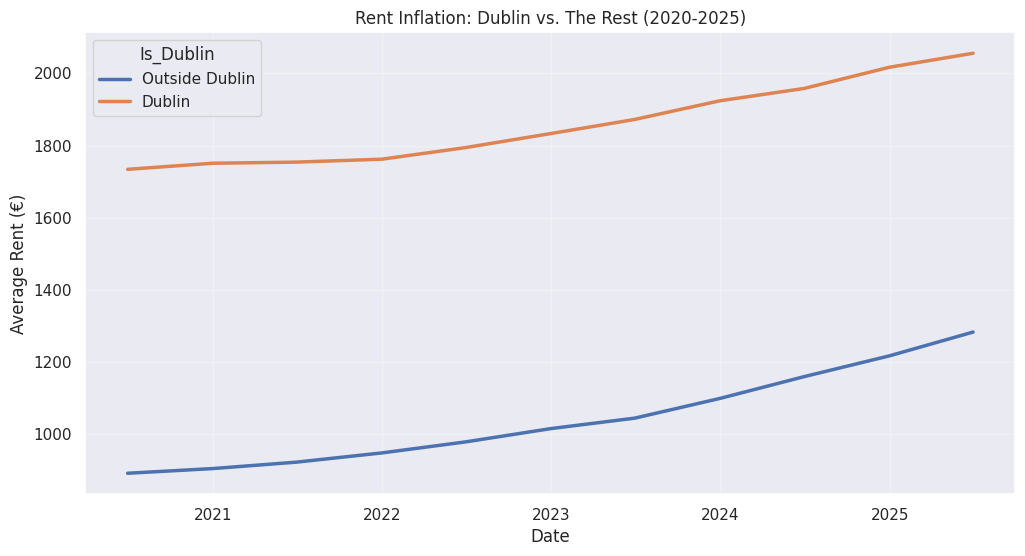

In [64]:
from scipy import stats

print("--- 1. FIXING TIME (CONVERTING QUARTERS TO DATES) ---")

# Adjusting column names based on your actual data!
# Using 'half_year' directly for date conversion
if 'half_year' in df.columns and 'year' in df.columns:
    # Extract year and half from 'half_year' to create a consistent date.
    # For simplicity and consistency, let's assume H1 ends on June 30 and H2 on December 31
    def get_date_from_half_year(row):
        year = str(row['year'])
        half = str(row['half'])
        if half == '1':
            return f'{year}-06-30'
        elif half == '2':
            return f'{year}-12-31'
        return None

    df['Date_Str'] = df.apply(get_date_from_half_year, axis=1)
    df['Date'] = pd.to_datetime(df['Date_Str'])
    df = df.sort_values('Date')
    print(f"✅ Time Series Created. Range: {df['Date'].min()} to {df['Date'].max()}")
else:
    print("⚠️ Column names 'year'/'half_year' not found. Please check df.columns!")

print("\n--- 2. THE 'DUBLIN PREMIUM' (STATISTICAL TEST) ---")

# Question: Is rent in Dublin significantly higher than the rest of the country?
# We create a new column: "Is_Dublin" using the correct 'county' column
df['Is_Dublin'] = df['county'].apply(lambda x: 'Dublin' if 'Dublin' in str(x) else 'Outside Dublin')

# T-Test using the correct 'rent_euro' column
dublin_rents = df[df['Is_Dublin'] == 'Dublin']['rent_euro']
other_rents = df[df['Is_Dublin'] == 'Outside Dublin']['rent_euro']

t_stat, p_val = stats.ttest_ind(dublin_rents, other_rents, nan_policy='omit')

print(f"Average Rent (Dublin): €{dublin_rents.mean():,.0f}")
print(f"Average Rent (Outside): €{other_rents.mean():,.0f}")
print(f"T-Test P-Value: {p_val:.4e}")

if p_val < 0.05:
    print("✅ RESULT: The 'Dublin Premium' is statistically significant.")
else:
    print("❌ RESULT: No significant difference found.")

# Visualization
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Date', y='rent_euro', hue='Is_Dublin', ci=None, linewidth=2.5)
plt.title('Rent Inflation: Dublin vs. The Rest (2020-2025)')
plt.ylabel('Average Rent (€)')
plt.grid(True, alpha=0.3)
plt.show()

### Advanced Time Series

--- 3. CALCULATING RENT INFLATION (YoY Growth) ---
✅ YoY Growth Calculated. (Example: If Rent went €1000 -> €1100, Growth = 10%)


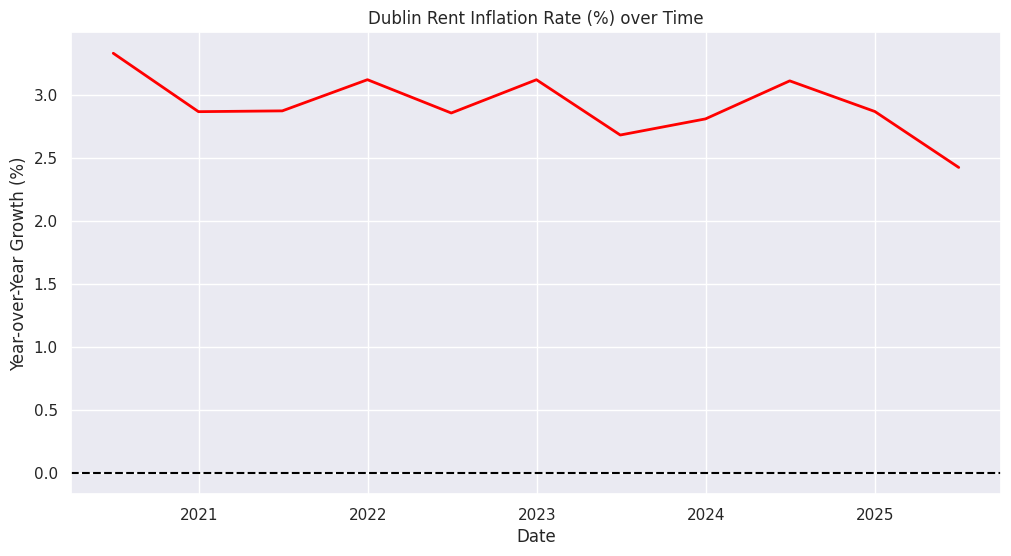


--- 4. PREDICTING 2026 (SIMPLE TREND FORECAST) ---
🔮 RENT FORECAST FOR NEXT 12 MONTHS:
   2025-09-30: €1,487.02
   2025-12-31: €1,501.91
   2026-03-31: €1,516.47
   2026-06-30: €1,531.19


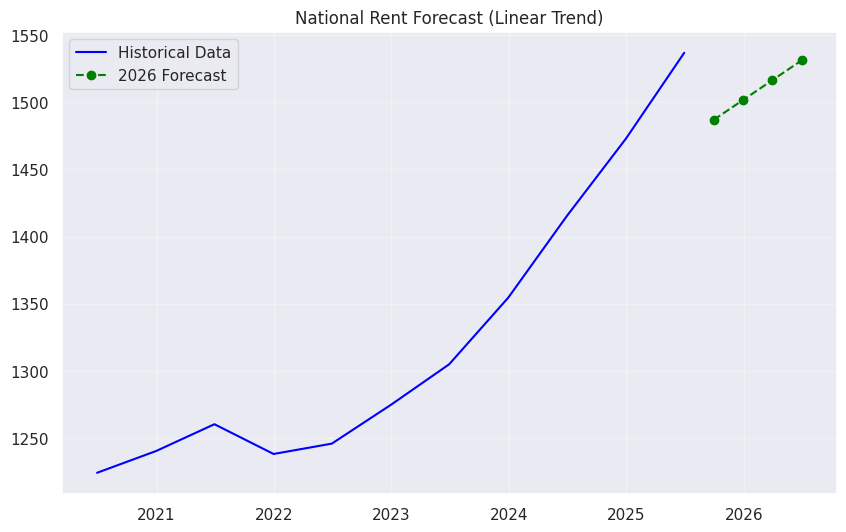

In [65]:
from sklearn.linear_model import LinearRegression

print("--- 3. CALCULATING RENT INFLATION (YoY Growth) ---")

# 1. Calculating Year-over-Year Growth
# We group by County to ensure we don't mix up different locations
# pct_change(4) compares "This Quarter" vs "Same Quarter Last Year"
df['Rent_Growth_YoY'] = df.groupby('county')['rent_euro'].pct_change(periods=4) * 100

print("✅ YoY Growth Calculated. (Example: If Rent went €1000 -> €1100, Growth = 10%)")

# Visualize The "Acceleration" of Crisis
plt.figure(figsize=(12, 6))
# Filtering for Dublin to see the specific trend
dublin_data = df[df['county'].str.contains('Dublin')]
sns.lineplot(data=dublin_data, x='Date', y='Rent_Growth_YoY', ci=None, color='red', linewidth=2)
plt.axhline(0, color='black', linestyle='--') # The "Zero Growth" line
plt.title('Dublin Rent Inflation Rate (%) over Time')
plt.ylabel('Year-over-Year Growth (%)')
plt.show()


print("\n--- 4. PREDICTING 2026 (SIMPLE TREND FORECAST) ---")
# Since we have small data (5 years), a Linear Trend is safer than ARIMA.
# Let's predict the trend for the whole country.
# Prepare Data for Regression (Convert Dates to Ordinal Numbers)
trend_data = df.groupby('Date')['rent_euro'].mean().reset_index()
trend_data['Time_Index'] = trend_data['Date'].map(pd.Timestamp.toordinal)

X = trend_data[['Time_Index']]
y = trend_data['rent_euro']

# Train Linear Model
model = LinearRegression()
model.fit(X, y)

# Create Future Dates (Next 4 Quarters)
last_date = trend_data['Date'].max()
future_dates = pd.date_range(start=last_date, periods=5, freq='Q')[1:] # Next 4 quarters
future_X = pd.DataFrame(future_dates.map(pd.Timestamp.toordinal), columns=['Time_Index'])

# Predict
future_preds = model.predict(future_X)

print("🔮 RENT FORECAST FOR NEXT 12 MONTHS:")
for date, price in zip(future_dates, future_preds):
    print(f"   {date.date()}: €{price:,.2f}")

# Plotting the Forecast
plt.figure(figsize=(10, 6))
plt.plot(trend_data['Date'], y, label='Historical Data', color='blue')
plt.plot(future_dates, future_preds, label='2026 Forecast', color='green', linestyle='--', marker='o')
plt.title('National Rent Forecast (Linear Trend)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Hypothesis Testing

--- 1. DISTRIBUTION ANALYSIS (THE SHAPE OF THE MARKET) ---


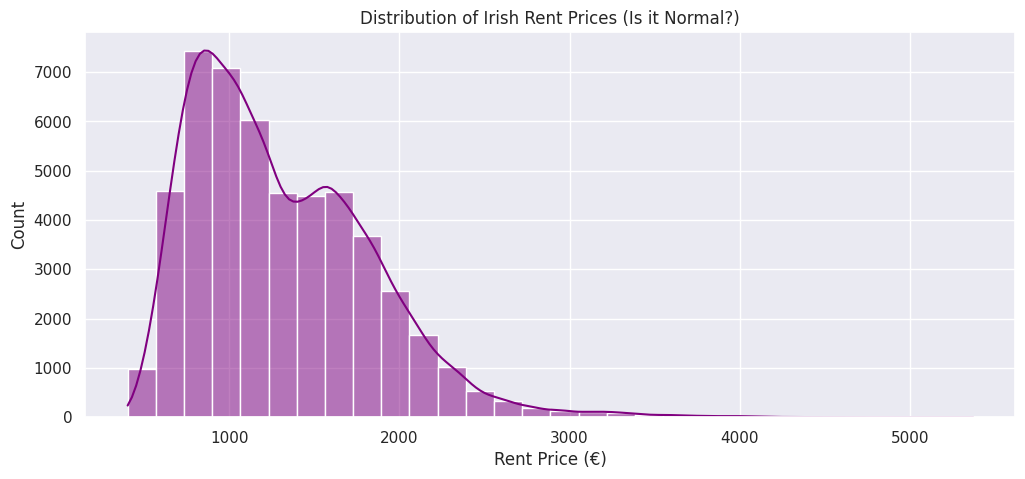

📊 INSIGHT: If this graph has a 'Long Tail' to the right, the market is skewed by luxury rentals.

--- 2. THE 'DUBLIN PREMIUM' (T-TEST) ---
💰 Average Rent (Dublin):   €1,831
💰 Average Rent (Country):  €1,023
📉 P-Value: 0.0000e+00
✅ VERDICT: The 'Dublin Premium' is statistically significant.

--- 3. DOES COUNTY MATTER? (ANOVA TEST) ---
Testing variance between: ['Dublin', 'Cork', 'Galway', 'Kildare', 'Meath']
📉 ANOVA P-Value: 0.0000e+00
✅ VERDICT: Location is a primary driver of price (Counties are distinct markets).


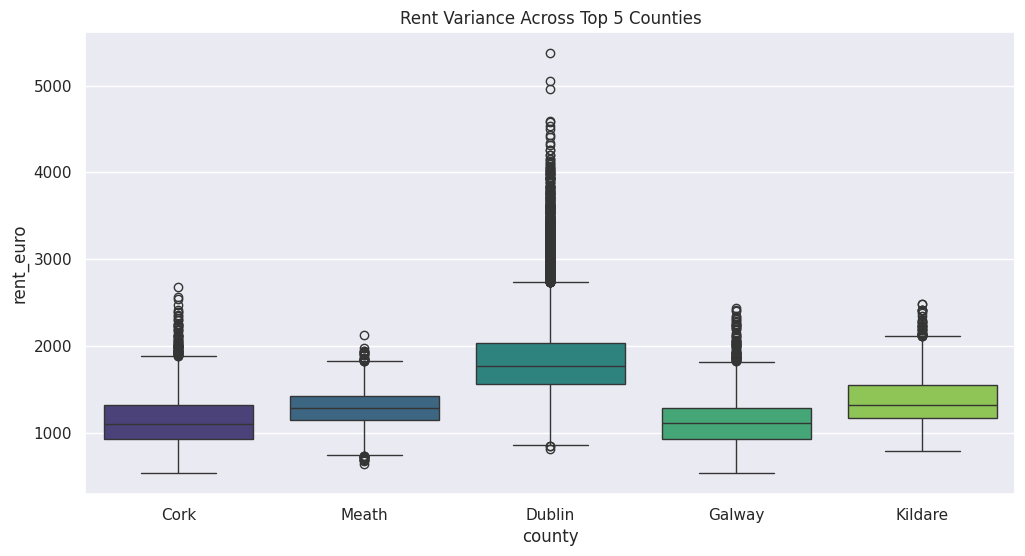

In [66]:
from scipy import stats

print("--- 1. DISTRIBUTION ANALYSIS (THE SHAPE OF THE MARKET) ---")

# 1. Visual Normality Check
plt.figure(figsize=(12, 5))
sns.histplot(df['rent_euro'], kde=True, color='purple', bins=30)
plt.title('Distribution of Irish Rent Prices (Is it Normal?)')
plt.xlabel('Rent Price (€)')
plt.show()

print("📊 INSIGHT: If this graph has a 'Long Tail' to the right, the market is skewed by luxury rentals.")


print("\n--- 2. THE 'DUBLIN PREMIUM' (T-TEST) ---")
# Hypothesis: Dublin rents are significantly different from non-Dublin rents.
# P-Value < 0.05 means the difference is REAL.
dublin_rents = df[df['county'].str.contains('Dublin', case=False)]['rent_euro']
country_rents = df[~df['county'].str.contains('Dublin', case=False)]['rent_euro']

# Run T-Test
t_stat, p_val = stats.ttest_ind(dublin_rents, country_rents, nan_policy='omit')

print(f"💰 Average Rent (Dublin):   €{dublin_rents.mean():,.0f}")
print(f"💰 Average Rent (Country):  €{country_rents.mean():,.0f}")
print(f"📉 P-Value: {p_val:.4e}")  # Scientific notation (e.g., 1.2e-50 is 0.0000...)

if p_val < 0.05:
    print("✅ VERDICT: The 'Dublin Premium' is statistically significant.")
else:
    print("❌ VERDICT: No significant difference found (Unlikely).")


print("\n--- 3. DOES COUNTY MATTER? (ANOVA TEST) ---")
# Hypothesis: Rent prices vary significantly across different Counties.
# We test the Top 5 most active counties to see if they are distinct markets.

# Get Top 5 Counties by data volume
top_counties = df['county'].value_counts().head(5).index.tolist()
print(f"Testing variance between: {top_counties}")

# Create groups for ANOVA
county_groups = [df[df['county'] == c]['rent_euro'] for c in top_counties]

# Run ANOVA
f_stat, p_val_anova = stats.f_oneway(*county_groups)

print(f"📉 ANOVA P-Value: {p_val_anova:.4e}")

if p_val_anova < 0.05:
    print("✅ VERDICT: Location is a primary driver of price (Counties are distinct markets).")
else:
    print("❌ VERDICT: Location does not significantly drive price differences.")

# Visualizing the ANOVA
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[df['county'].isin(top_counties)], x='county', y='rent_euro', palette='viridis')
plt.title('Rent Variance Across Top 5 Counties')
plt.show()

### Ranking & Dynamics

--- 1. RANKING THE COUNTIES (TUKEY'S HSD TEST) ---
✅ Tukey Test Complete. Here are significant differences (True):
  group1   group2  meandiff  p-adj     lower     upper  reject
0   Cork   Dublin  689.5012    0.0  670.1556  708.8468    True
2   Cork    Kerry -250.5748    0.0 -286.7554 -214.3942    True
3   Cork  Kildare  219.5722    0.0  190.3870  248.7574    True
5   Cork     Mayo -338.5518    0.0 -374.5834 -302.5202    True
6   Cork    Meath  140.4798    0.0  108.4533  172.5063    True


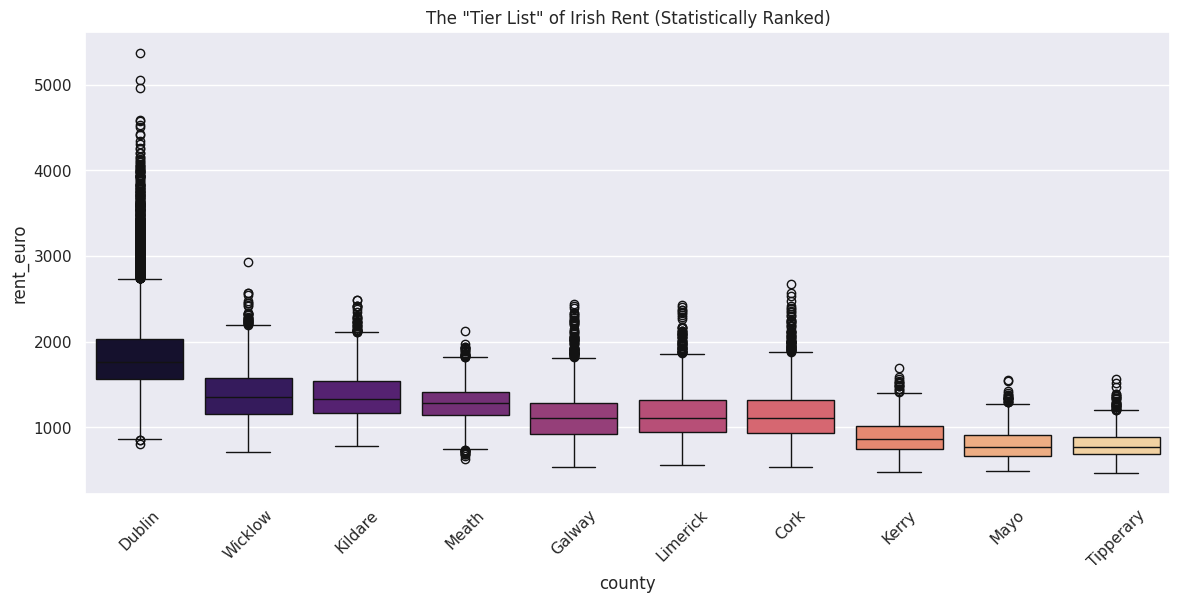


--- 2. INTERACTION ANALYSIS (IS THE GAP WIDENING?) ---


<Figure size 1200x600 with 0 Axes>

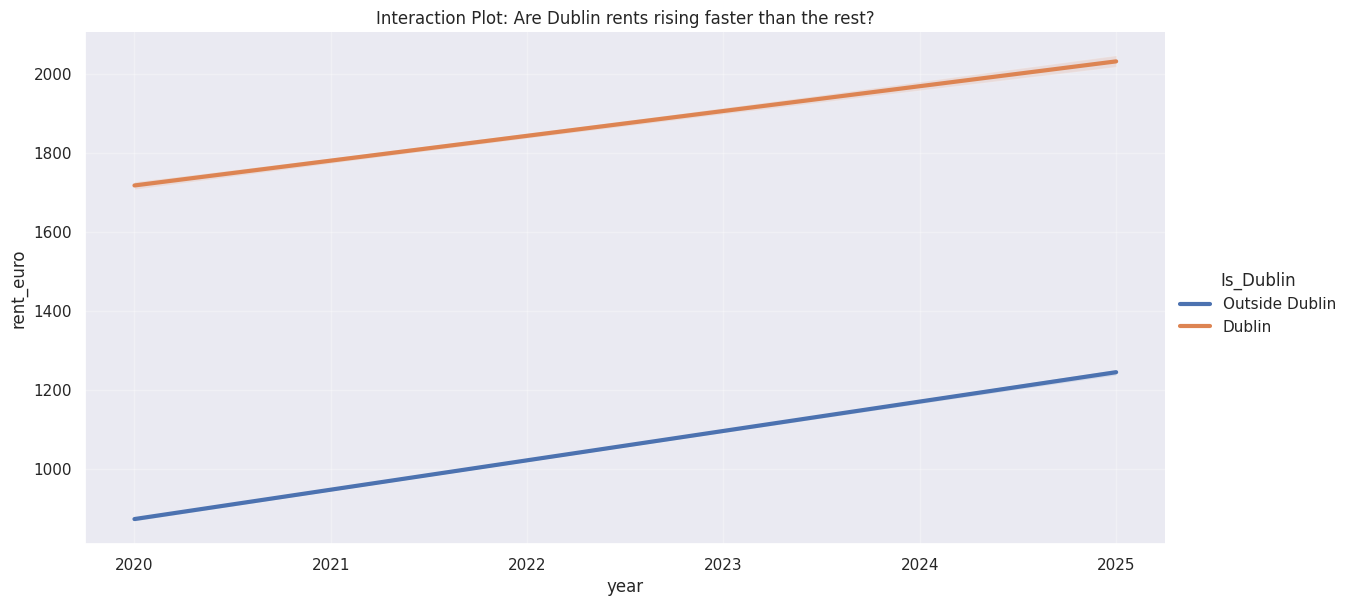

📊 INSIGHT:
   - Parallel Lines = The 'Dublin Premium' is constant (stable gap).
   - Diverging Lines (<) = The gap is getting WORSE (inequality increasing).


In [67]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

print("--- 1. RANKING THE COUNTIES (TUKEY'S HSD TEST) ---")
# This test compares every county against every other county to see specific differences.

# Let's filter for the Top 10 most active counties to keep the chart readable
top_10_counties = df['county'].value_counts().head(10).index.tolist()
subset_df = df[df['county'].isin(top_10_counties)]

# Run Tukey's Test
tukey = pairwise_tukeyhsd(endog=subset_df['rent_euro'],
                          groups=subset_df['county'],
                          alpha=0.05)

# Convert to DataFrame for easier reading
tukey_data = pd.DataFrame(data=tukey.summary().data[1:], columns=tukey.summary().data[0])
print("✅ Tukey Test Complete. Here are significant differences (True):")
print(tukey_data[tukey_data['reject'] == True].head())

# Visualizing the Hierarchy
plt.figure(figsize=(14, 6))
# Sort counties by Median Price for the chart
sorted_order = subset_df.groupby('county')['rent_euro'].median().sort_values(ascending=False).index
sns.boxplot(data=subset_df, x='county', y='rent_euro', order=sorted_order, palette='magma')
plt.title('The "Tier List" of Irish Rent (Statistically Ranked)')
plt.xticks(rotation=45)
plt.show()


print("\n--- 2. INTERACTION ANALYSIS (IS THE GAP WIDENING?) ---")
# We visualize if the trend lines for "Dublin" vs "Outside Dublin" are parallel or diverging.

plt.figure(figsize=(12, 6))
sns.lmplot(x="year", y="rent_euro", hue="Is_Dublin", data=df, aspect=2, height=6, scatter=False, line_kws={'linewidth': 3})
plt.title('Interaction Plot: Are Dublin rents rising faster than the rest?')
plt.grid(True, alpha=0.3)
plt.show()

print("📊 INSIGHT:")
print("   - Parallel Lines = The 'Dublin Premium' is constant (stable gap).")
print("   - Diverging Lines (<) = The gap is getting WORSE (inequality increasing).")

# Feature Analysis

--- 1. CREATING 'MEMORY' FEATURES (LAGS & TRENDS) ---
✅ Created 5 New Features: [Lag_1, Lag_2, Lag_4, Rolling_Mean, Velocity]
   (Note: First few rows will have NaNs because they have no history. We will drop them.)

--- 2. CORRELATION MATRIX (LINEAR RELATIONSHIPS) ---


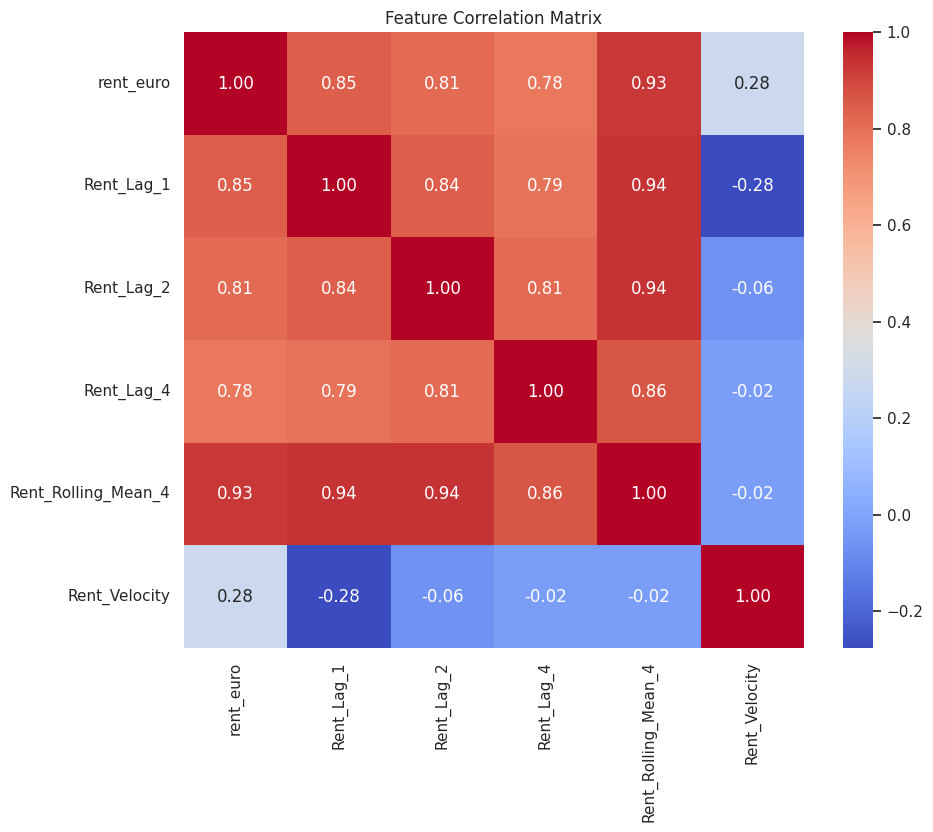


--- 3. RANDOM FOREST FEATURE IMPORTANCE (NON-LINEAR) ---


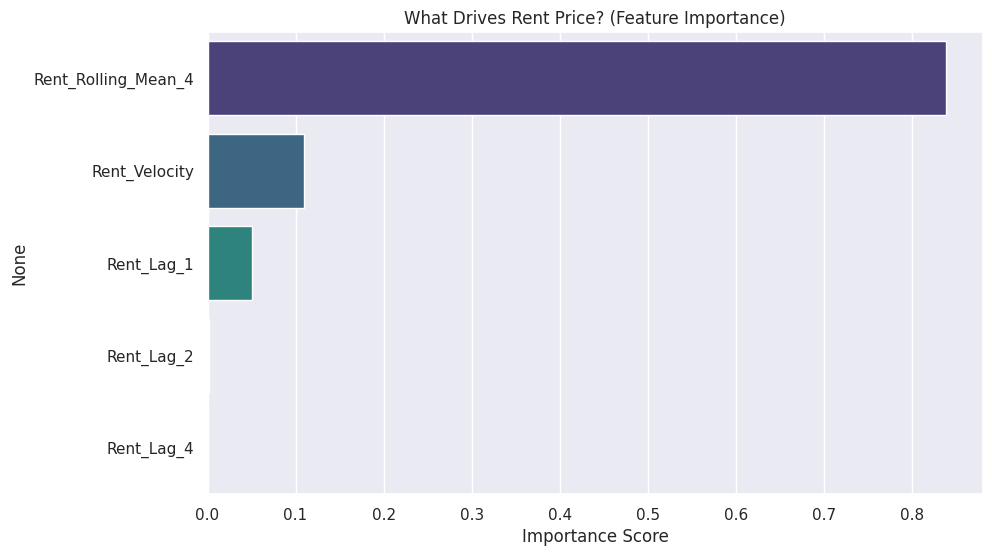

In [56]:
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import matplotlib.pyplot as plt

print("--- 1. CREATING 'MEMORY' FEATURES (LAGS & TRENDS) ---")
# We need to tell the model what happened in the past.
# CRITICAL: We must group by 'county' so we don't mix Dublin's past with Galway's future.

# 1. Lag Features (What was rent X quarters ago?)
df['Rent_Lag_1'] = df.groupby('county')['rent_euro'].shift(1) # Last Quarter
df['Rent_Lag_2'] = df.groupby('county')['rent_euro'].shift(2) # 6 Months ago
df['Rent_Lag_4'] = df.groupby('county')['rent_euro'].shift(4) # 1 Year ago (Same season)

# 2. Rolling Features (What is the recent trend?)
# Average rent over the last 4 quarters (Annual Average)
df['Rent_Rolling_Mean_4'] = df.groupby('county')['rent_euro'].transform(lambda x: x.rolling(4).mean())

# 3. Momentum (Velocity of change)
# Difference between now and last quarter
df['Rent_Velocity'] = df['rent_euro'] - df['Rent_Lag_1']

print("✅ Created 5 New Features: [Lag_1, Lag_2, Lag_4, Rolling_Mean, Velocity]")
print("   (Note: First few rows will have NaNs because they have no history. We will drop them.)")

# Drop NaNs created by shifting
df_ml = df.dropna().copy()


print("\n--- 2. CORRELATION MATRIX (LINEAR RELATIONSHIPS) ---")
# Let's see which past feature correlates most with today's price.
# We select only numeric columns for the heatmap
numeric_cols = ['rent_euro', 'Rent_Lag_1', 'Rent_Lag_2', 'Rent_Lag_4', 'Rent_Rolling_Mean_4', 'Rent_Velocity']
corr = df_ml[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.show()

print("\n--- 3. RANDOM FOREST FEATURE IMPORTANCE (NON-LINEAR) ---")
# A simple model to rank features by "Importance"

# Prepare Data
features = ['Rent_Lag_1', 'Rent_Lag_2', 'Rent_Lag_4', 'Rent_Rolling_Mean_4', 'Rent_Velocity']
X = df_ml[features]
y = df_ml['rent_euro']

# Train Model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X, y)

# Extract & Plot Importance
importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=importances.values, y=importances.index, palette='viridis')
plt.title('What Drives Rent Price? (Feature Importance)')
plt.xlabel('Importance Score')
plt.show()

# Univariate Analysis

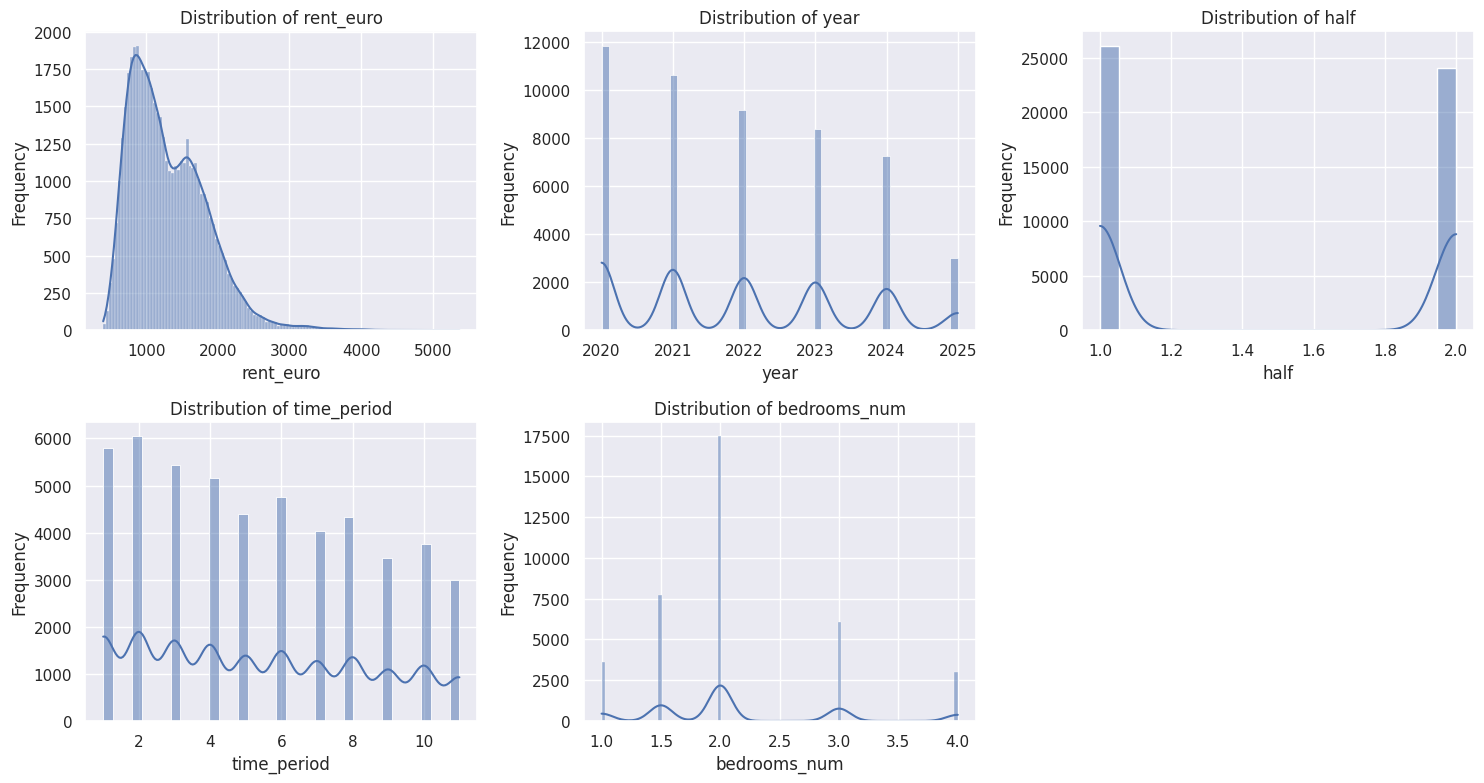

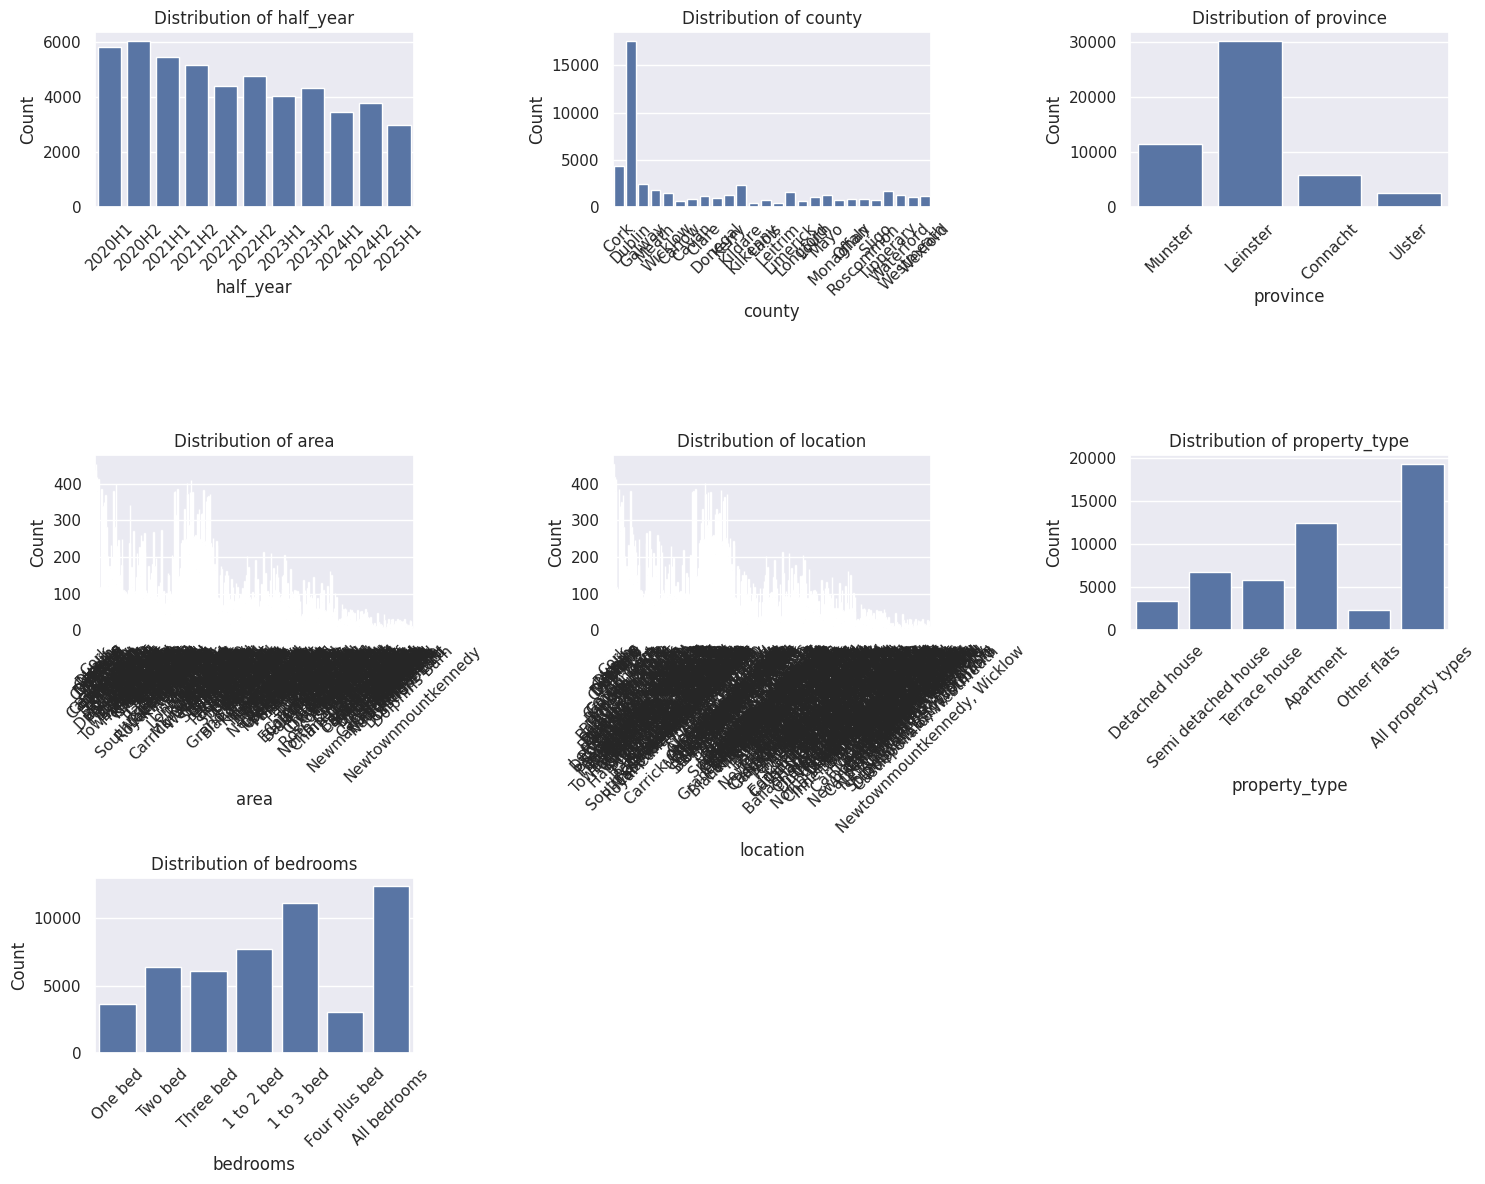

--- Categorical Value Counts ---

Value counts for half_year:
half_year
2020H2    6044
2020H1    5807
2021H1    5437
2021H2    5168
2022H2    4751
2022H1    4400
2023H2    4336
2023H1    4037
2024H2    3769
2024H1    3466
2025H1    2993
Name: count, dtype: int64

Value counts for county:
county
Dublin       17596
Cork          4374
Galway        2496
Kildare       2375
Meath         1806
Tipperary     1691
Limerick      1655
Wicklow       1501
Mayo          1313
Kerry         1299
Waterford     1272
Wexford       1200
Clare         1159
Louth         1065
Westmeath     1054
Donegal        975
Offaly         903
Roscommon      872
Cavan          869
Monaghan       830
Laois          826
Sligo          818
Carlow         714
Longford       683
Kilkenny       449
Leitrim        413
Name: count, dtype: int64

Value counts for province:
province
Leinster    30172
Munster     11450
Connacht     5912
Ulster       2674
Name: count, dtype: int64

Value counts for area:
area
Dublin              

In [41]:
import math

# --- 1. Numerical Columns (Histograms in a Grid) ---
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()

if len(numerical_cols) > 0:
    # Define grid size
    num_plots = len(numerical_cols)
    num_cols = 3  # You can change this to 2 or 4 if preferred
    num_rows = math.ceil(num_plots / num_cols)

    # Create figure and axes
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 4 * num_rows))
    axes = axes.flatten()  # Flatten to 1D array for easy iteration

    # Iterate and plot
    for i, col in enumerate(numerical_cols):
        sns.histplot(data=df, x=col, kde=True, ax=axes[i])
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')

    # Hidding any unused subplots (if total plots < grid cells)
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No numerical columns found.")


# --- 2. Categorical Columns (Countplots in a Grid) ---
categorical_cols = df.select_dtypes(include='object').columns.tolist()

if len(categorical_cols) > 0:
    # Define grid size
    num_plots = len(categorical_cols)
    num_cols = 3
    num_rows = math.ceil(num_plots / num_cols)

    # Create figure and axes
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 4 * num_rows))
    axes = axes.flatten()

    # Iterate and plot
    for i, col in enumerate(categorical_cols):
        sns.countplot(data=df, x=col, ax=axes[i])
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Count')
        axes[i].tick_params(axis='x', rotation=45)

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

    # --- 3. Value Counts (Text Output) ---
    print("--- Categorical Value Counts ---")
    for col in categorical_cols:
        print(f"\nValue counts for {col}:")
        print(df[col].value_counts())
else:
    print("No categorical columns found.")

# Bivariate Analysis

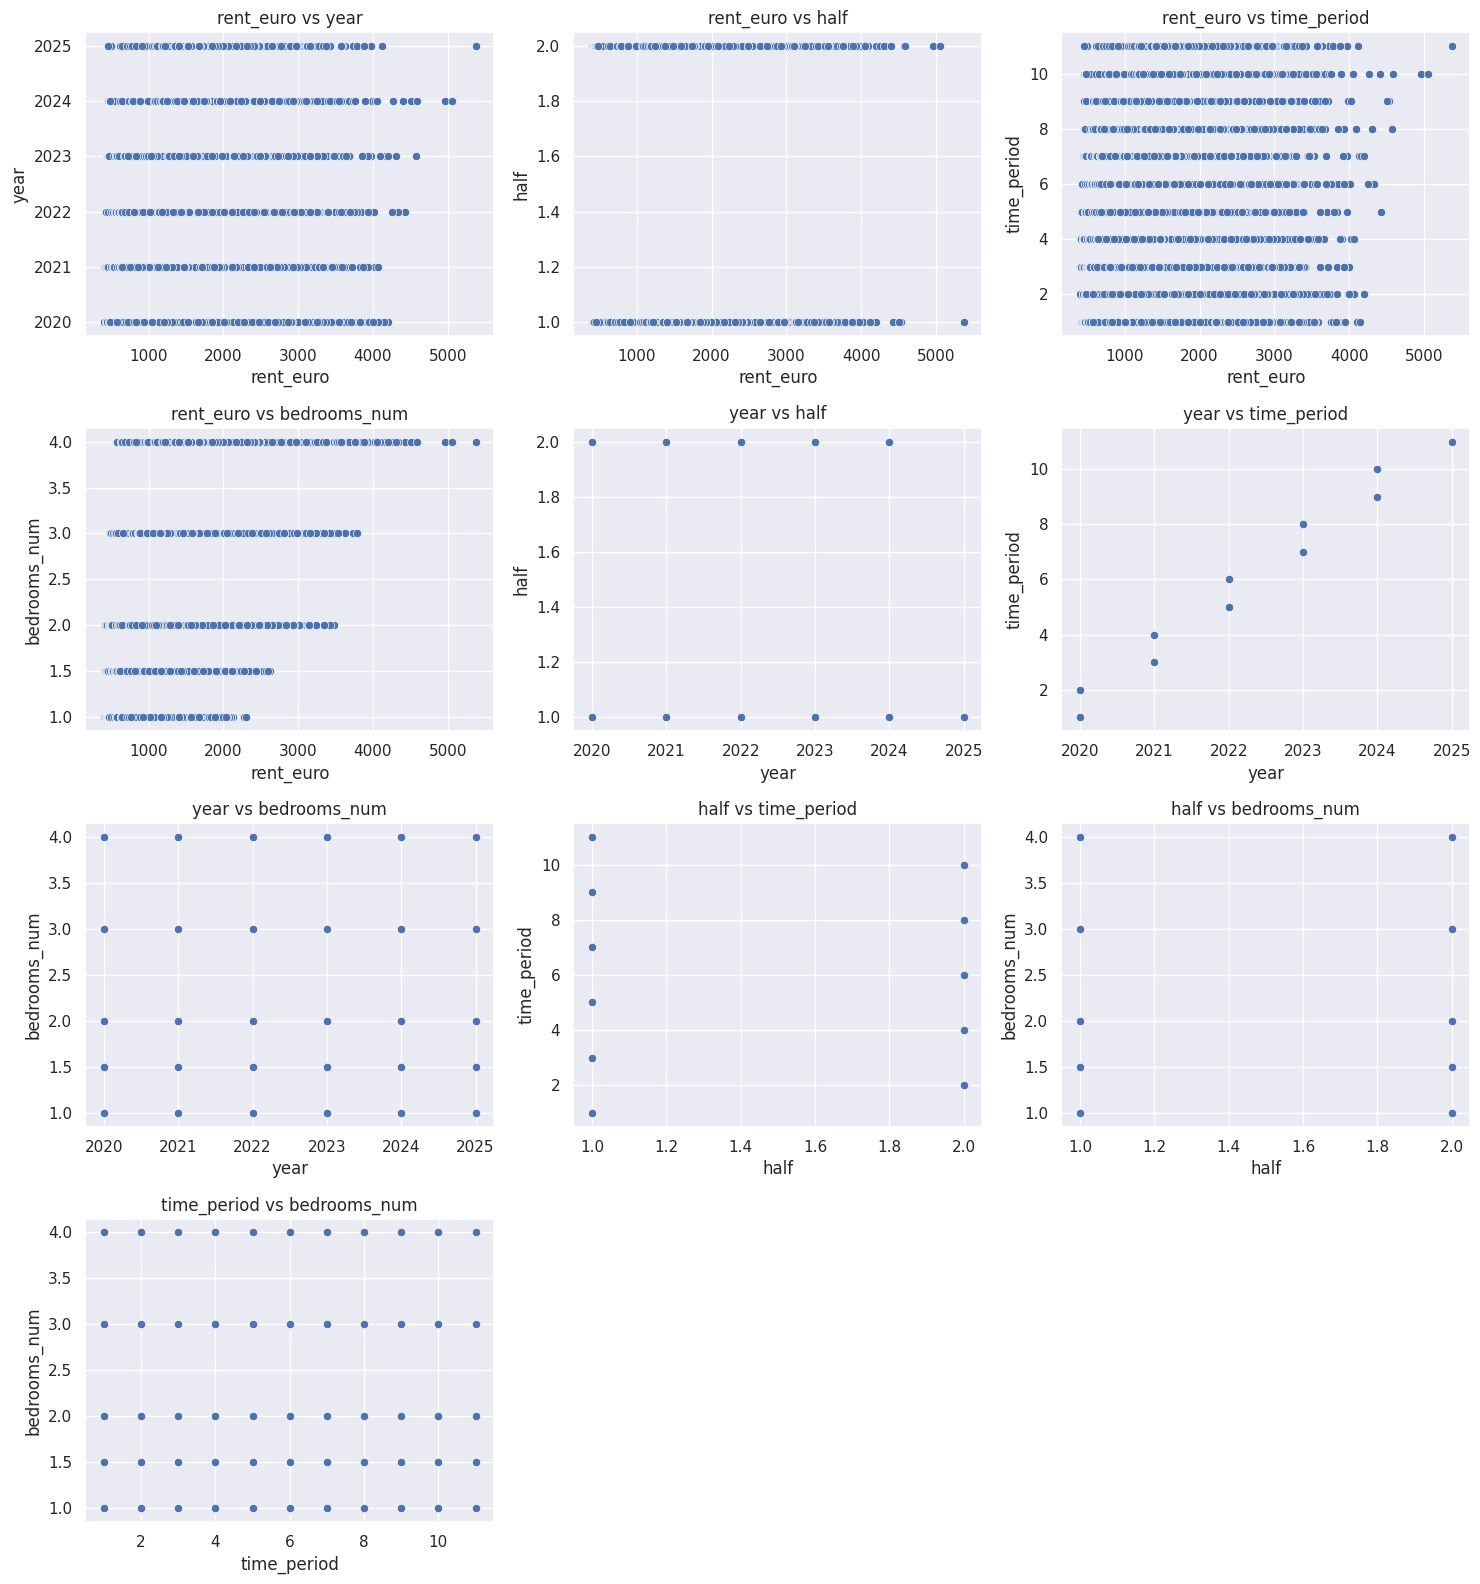

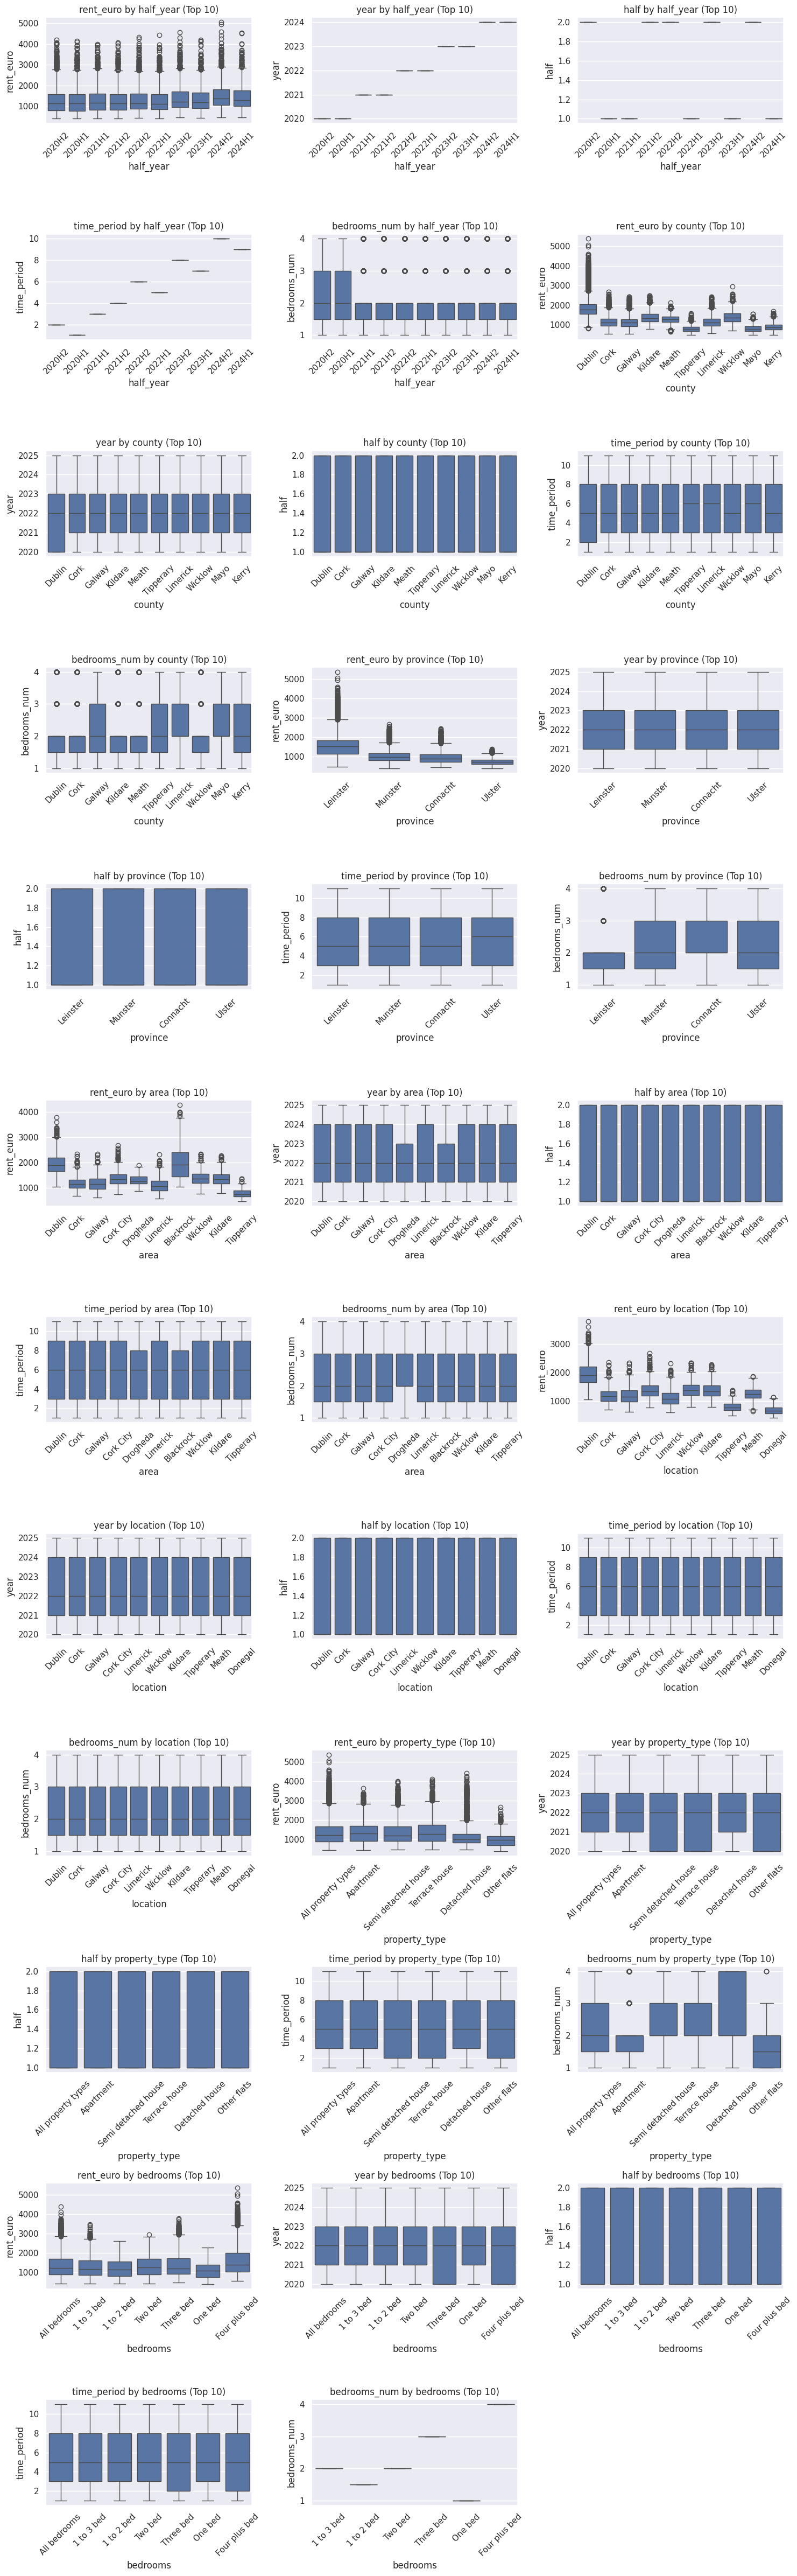

In [42]:
import itertools

# --- 1. Numerical-Numerical Relationships (Scatter Plots) ---
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()

# Generate all unique pairs of numerical columns
num_pairs = list(itertools.combinations(numerical_cols, 2))

if len(num_pairs) > 0:
    # Define grid size
    num_plots = len(num_pairs)
    num_cols = 3
    num_rows = math.ceil(num_plots / num_cols)

    # Create figure and axes
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 4 * num_rows))

    # Flatten axes for easy iteration.
    # Handle edge case where there is only 1 plot (axes is not an array)
    if num_plots == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    # Iterate through pairs and plot
    for i, (col1, col2) in enumerate(num_pairs):
        sns.scatterplot(data=df, x=col1, y=col2, ax=axes[i])
        axes[i].set_title(f'{col1} vs {col2}')
        axes[i].set_xlabel(col1)
        axes[i].set_ylabel(col2)

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("Not enough numerical columns for scatter plots.")


# --- 2. Categorical-Numerical Relationships (Box Plots) ---
categorical_cols = df.select_dtypes(include='object').columns.tolist()
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()

# Generate all pairs of (Categorical, Numerical)
cat_num_pairs = list(itertools.product(categorical_cols, numerical_cols))

if len(cat_num_pairs) > 0:
    # Define grid size
    num_plots = len(cat_num_pairs)
    num_cols = 3
    num_rows = math.ceil(num_plots / num_cols)

    # Create figure and axes
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 4 * num_rows))

    if num_plots == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    # Iterate through pairs and plot
    for i, (cat_col, num_col) in enumerate(cat_num_pairs):
        # 1. Get top 10 categories based on frequency
        top_categories = df[cat_col].value_counts().nlargest(10).index.tolist()

        # 2. Filter data: Keep only top categories AND ensure numerical column is not NaN
        filtered_df = df[df[cat_col].isin(top_categories) & df[num_col].notnull()]

        # 3. Update 'order' to only include categories that exist in the filtered data
        # This prevents the ValueError where a category in 'order' has no data to plot
        valid_categories = [cat for cat in top_categories if cat in filtered_df[cat_col].unique()]

        if valid_categories:
            sns.boxplot(data=filtered_df, x=cat_col, y=num_col, ax=axes[i], order=valid_categories)
            axes[i].set_title(f'{num_col} by {cat_col} (Top 10)')
            axes[i].set_xlabel(cat_col)
            axes[i].set_ylabel(num_col)
            axes[i].tick_params(axis='x', rotation=45)
        else:
             axes[i].text(0.5, 0.5, "No valid data", ha='center', va='center')

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("No categorical-numerical pairs found.")

# Multivariate Analysis

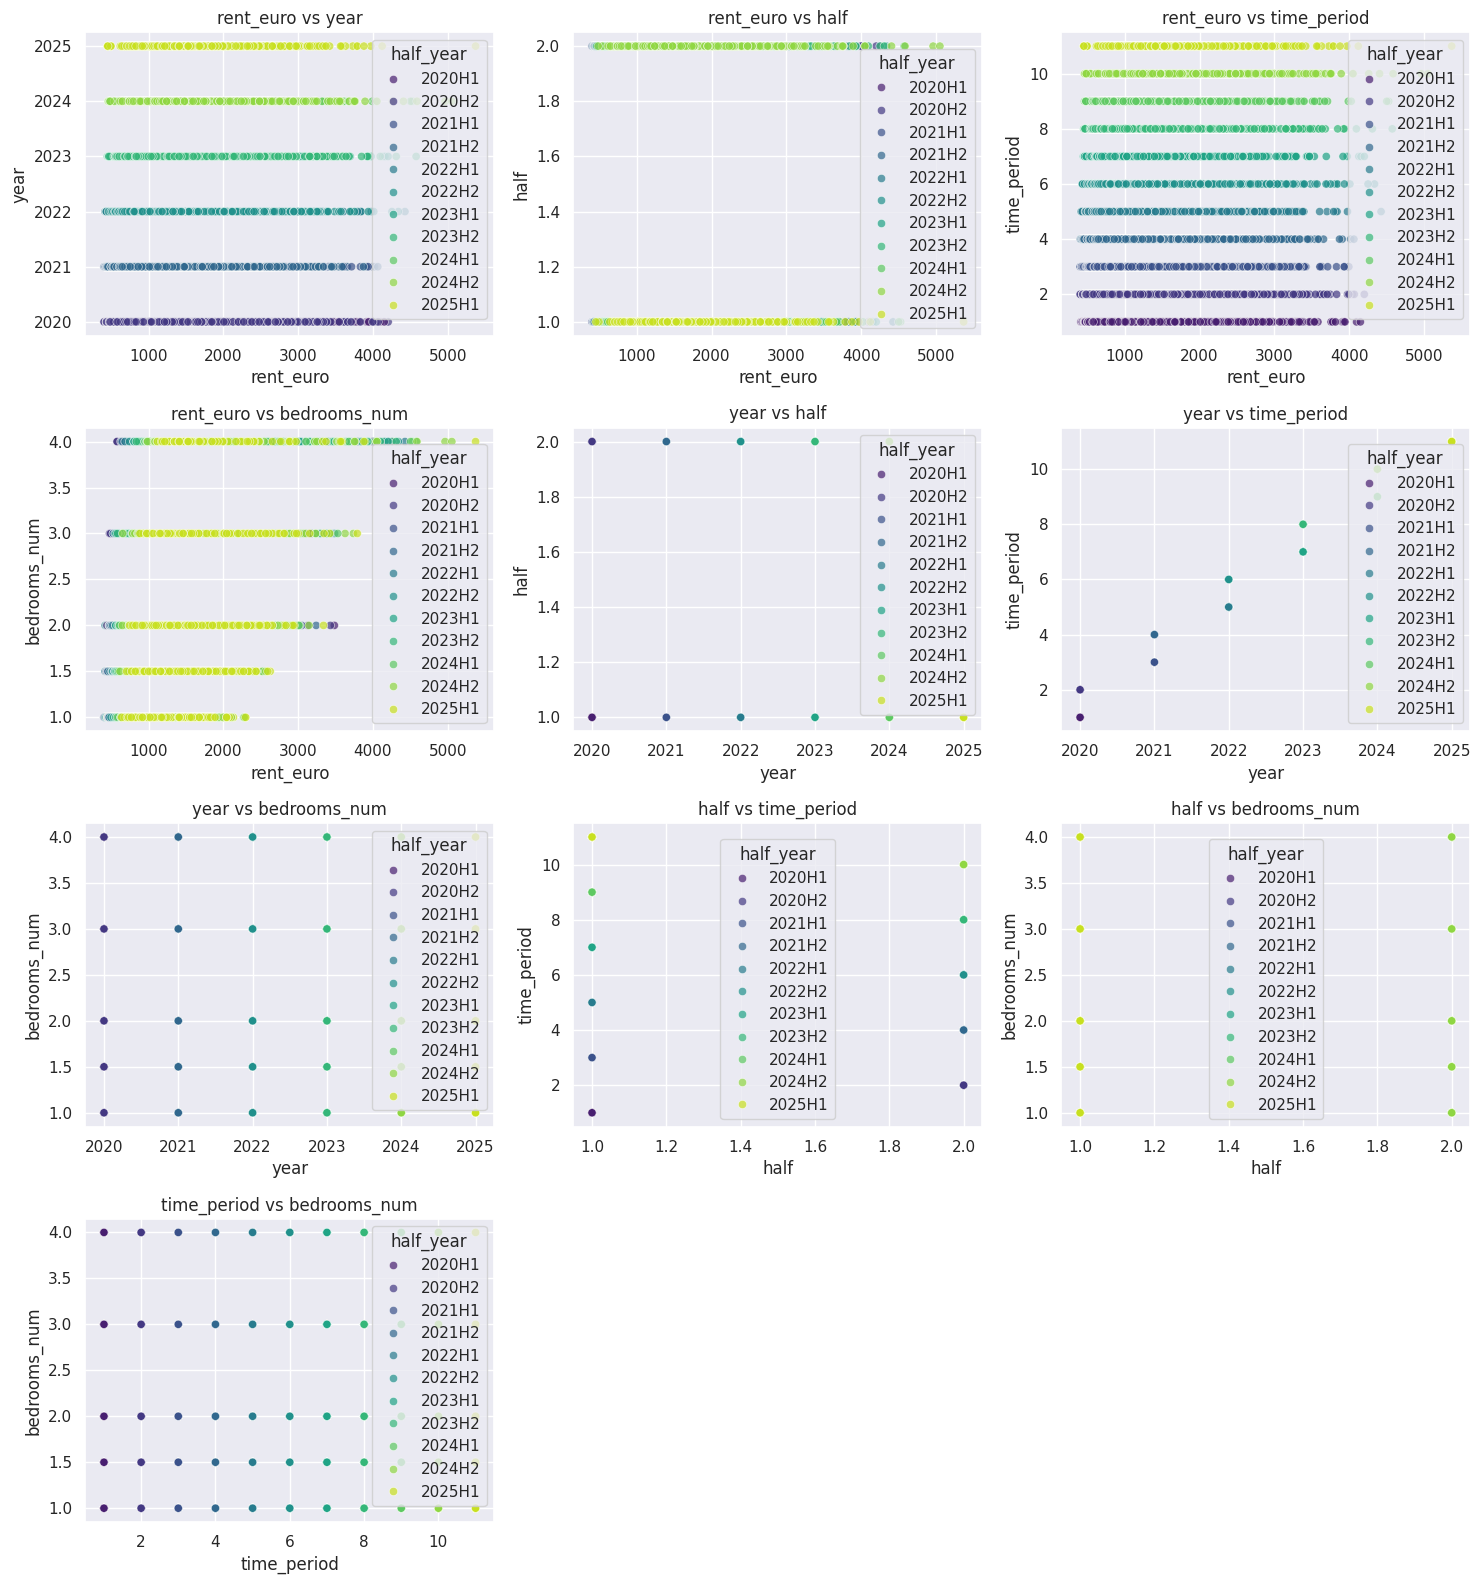


--- Multivariate Summary by 'half_year' (Loop Form) ---
Displaying mean values of numerical features for each category in 'half_year':

Category: 2020H1
rent_euro       1224.229513
year            2020.000000
half               1.000000
time_period        1.000000
bedrooms_num       2.156328
dtype: float64
------------------------------
Category: 2020H2
rent_euro       1240.483562
year            2020.000000
half               2.000000
time_period        2.000000
bedrooms_num       2.166847
dtype: float64
------------------------------
Category: 2021H1
rent_euro       1260.402255
year            2021.000000
half               1.000000
time_period        3.000000
bedrooms_num       2.135283
dtype: float64
------------------------------
Category: 2021H2
rent_euro       1238.242171
year            2021.000000
half               2.000000
time_period        4.000000
bedrooms_num       2.123372
dtype: float64
------------------------------
Category: 2022H1
rent_euro       1245.945568
year  

In [43]:
import itertools
import math

# --- 1. Multivariate Scatter Plots (Grid with Hue) ---

numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = df.select_dtypes(include='object').columns.tolist()

# We need at least 2 numerical columns and 1 categorical column to create this plot
if len(numerical_cols) >= 2 and len(categorical_cols) >= 1:
    # Use the first categorical column for the hue
    hue_col = categorical_cols[0]

    # Generate all unique pairs of numerical columns
    num_pairs = list(itertools.combinations(numerical_cols, 2))

    # Define grid size
    num_plots = len(num_pairs)
    num_cols = 3
    num_rows = math.ceil(num_plots / num_cols)

    # Create figure and axes
    # Using consistent size (5x4 per plot) as previous analyses
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 4 * num_rows))

    if num_plots == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    # Iterate and plot
    for i, (col1, col2) in enumerate(num_pairs):
        sns.scatterplot(data=df, x=col1, y=col2, hue=hue_col, ax=axes[i], alpha=0.7, palette='viridis')
        axes[i].set_title(f'{col1} vs {col2}')
        axes[i].set_xlabel(col1)
        axes[i].set_ylabel(col2)
        # Legend handling: keeping it simple for grid
        # axes[i].legend(loc='upper right', title=hue_col)

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("Not enough data for multivariate scatter plots.")


# --- 2. Multivariate Summary (Loop Form - Text Output) ---
# This mimics the 'Loop Form' textual analysis from previous steps

if len(categorical_cols) >= 1:
    hue_col = categorical_cols[0]
    print(f"\n--- Multivariate Summary by '{hue_col}' (Loop Form) ---")
    print(f"Displaying mean values of numerical features for each category in '{hue_col}':\n")

    # Loop through each category
    unique_cats = df[hue_col].unique()
    for cat in unique_cats:
        print(f"Category: {cat}")
        # Filter data and calculate mean
        subset = df[df[hue_col] == cat]
        print(subset[numerical_cols].mean())
        print("-" * 30)
else:
    print("No categorical column for loop summary.")

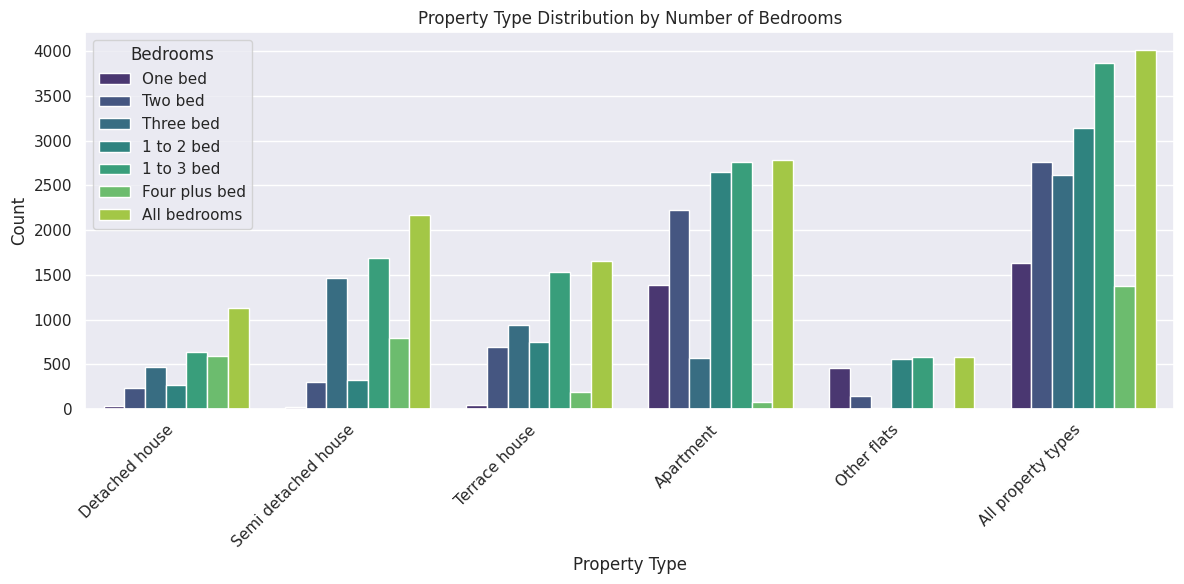

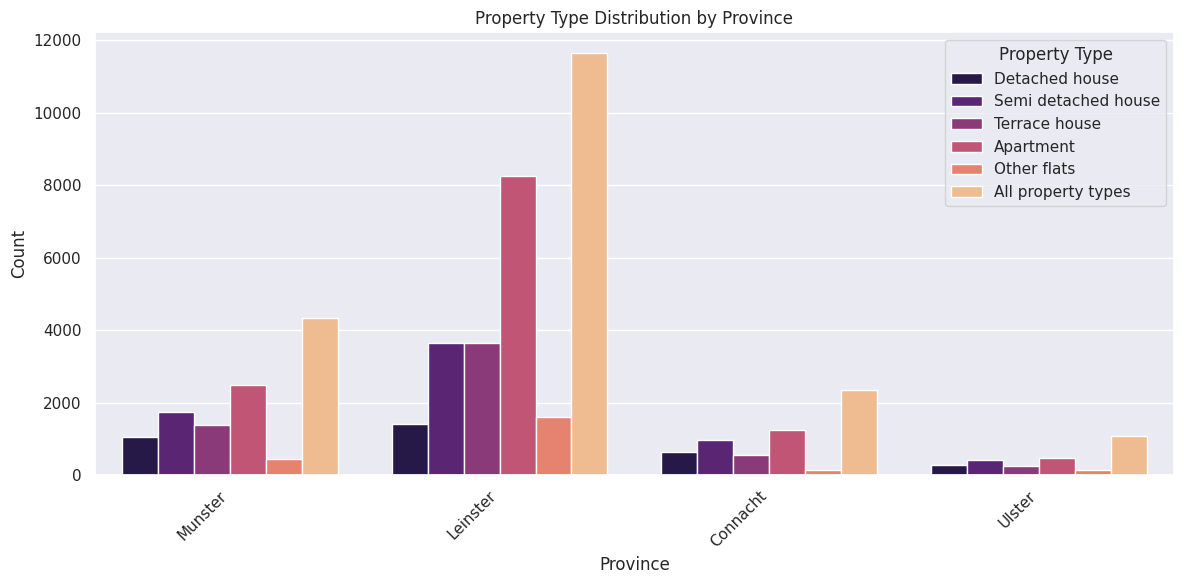

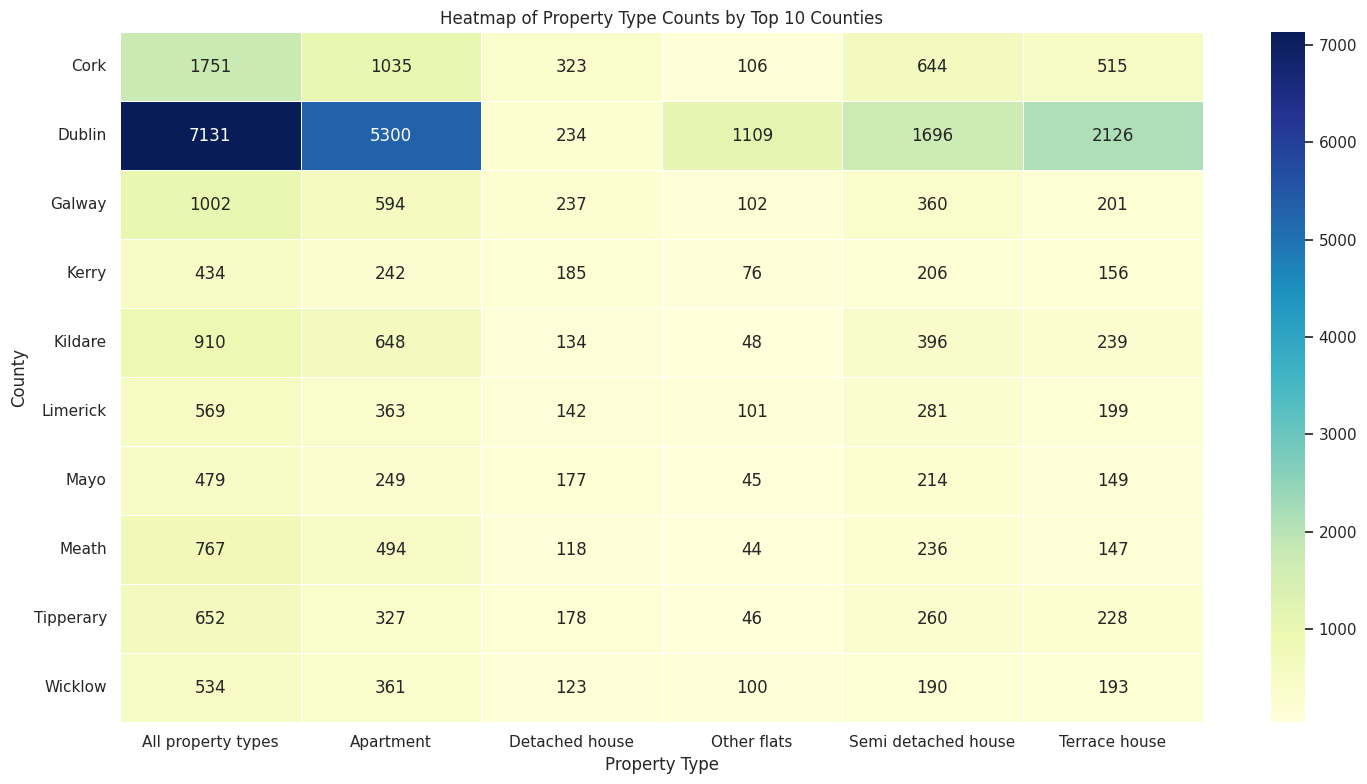

In [44]:
# --- Categorical-Categorical Relationships (Countplots and Heatmaps) ---
categorical_cols = df.select_dtypes(include='object').columns.tolist()

# Plotting Property Type vs Bedrooms
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='property_type', hue='bedrooms', palette='viridis')
plt.title('Property Type Distribution by Number of Bedrooms')
plt.xlabel('Property Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Bedrooms')
plt.tight_layout()
plt.show()

# Plotting Province vs Property Type
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='province', hue='property_type', palette='magma')
plt.title('Property Type Distribution by Province')
plt.xlabel('Province')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Property Type')
plt.tight_layout()
plt.show()

# Heatmap of Property Type by Top 10 Counties
# Get top 10 counties
top_10_counties = df['county'].value_counts().nlargest(10).index.tolist()
filtered_df_counties = df[df['county'].isin(top_10_counties)]

crosstab_county_property = pd.crosstab(filtered_df_counties['county'], filtered_df_counties['property_type'])

plt.figure(figsize=(15, 8))
sns.heatmap(crosstab_county_property, annot=True, fmt='d', cmap='YlGnBu', linewidths=.5)
plt.title('Heatmap of Property Type Counts by Top 10 Counties')
plt.xlabel('Property Type')
plt.ylabel('County')
plt.tight_layout()
plt.show()


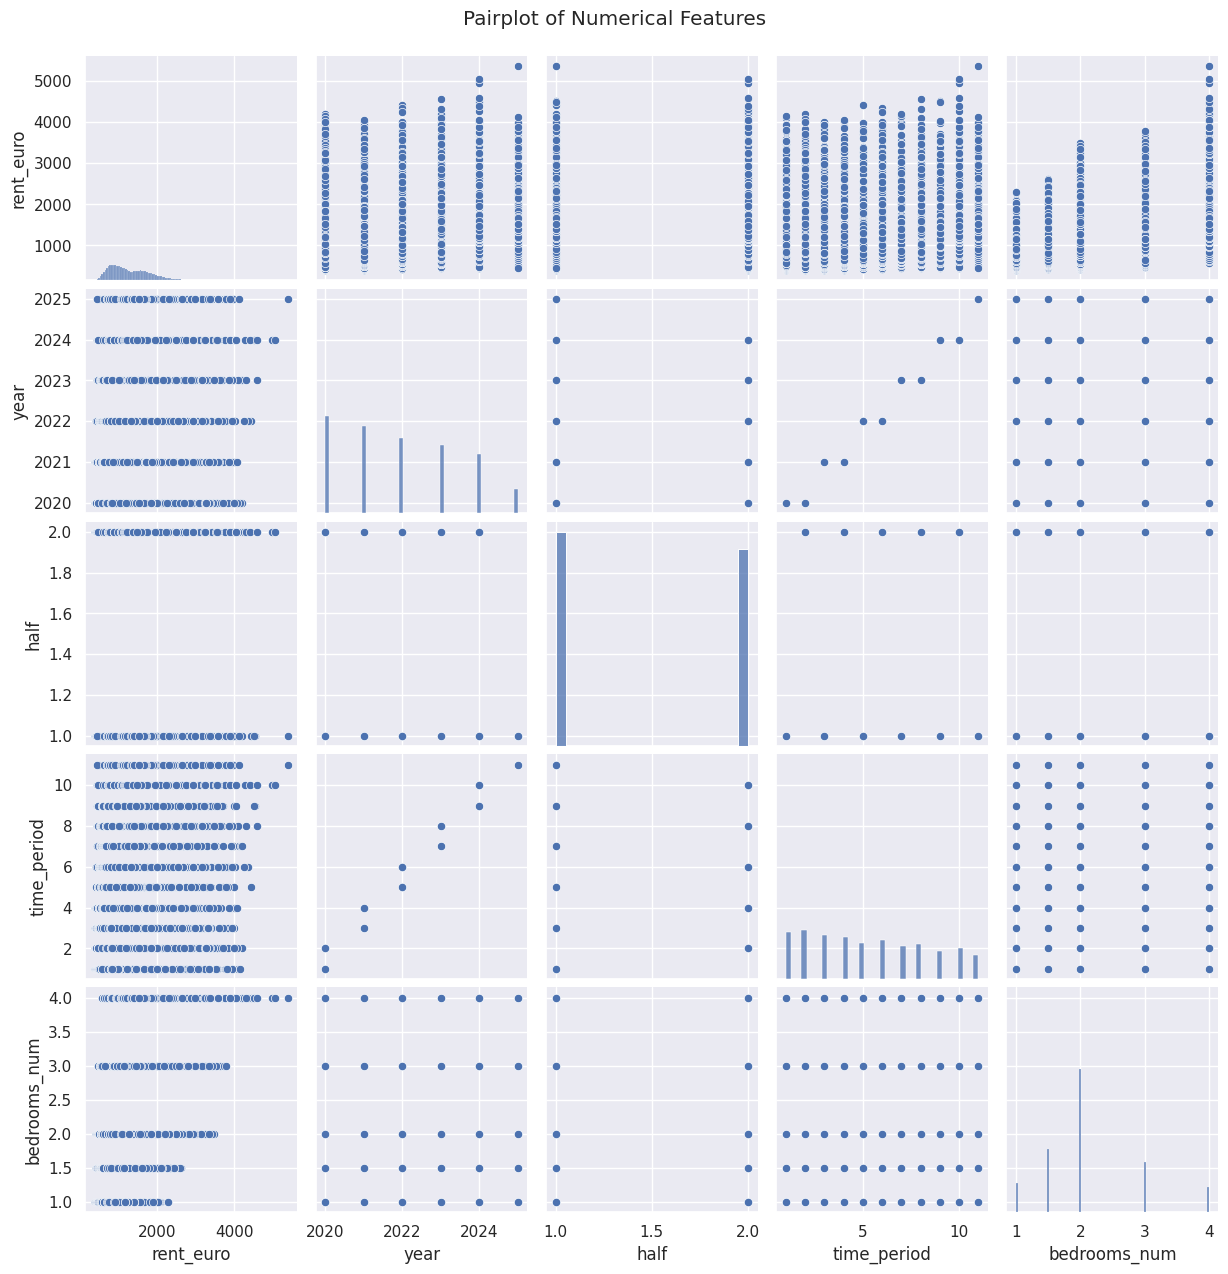

In [45]:
sns.pairplot(df.select_dtypes(include = np.number))
plt.suptitle('Pairplot of Numerical Features', y=1.02)
plt.show()

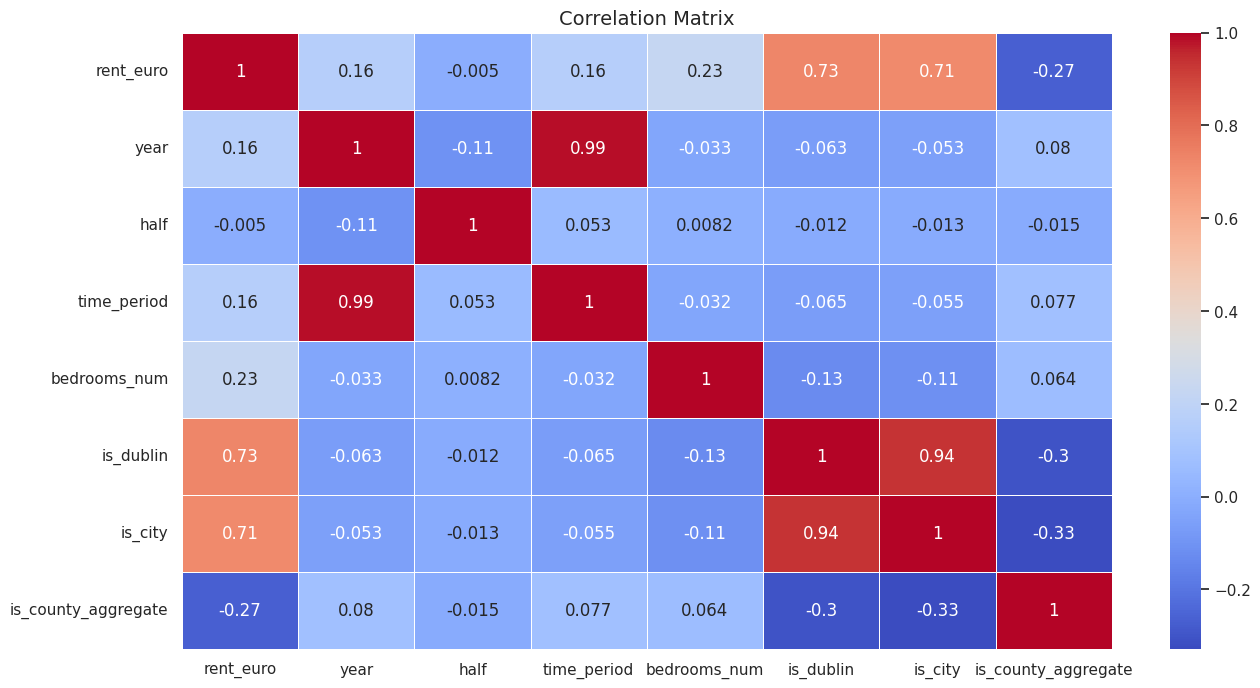

In [46]:
plt.figure(figsize=(15, 8))
sns.heatmap(df.corr(numeric_only = True), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix", fontsize=14)
plt.show()

# Machine Learning

--- 1. PREPARING THE MATRIX ---
Training with 872 features (Lags, Rolling Means, County Flags...)
Splitting Data. Training before: 2024-06-30
Train Size: 30272 samples | Test Size: 7592 samples

--- 2. TRAINING THE AI (GRADIENT BOOSTING) ---

--- 3. EVALUATION REPORT ---
💰 Average Prediction Error: €23.38
🎯 Model Accuracy (R2):      99.4%
⚠️ Error Margin:             1.6% (Lower is better)

--- 4. VISUALIZING REALITY VS AI ---


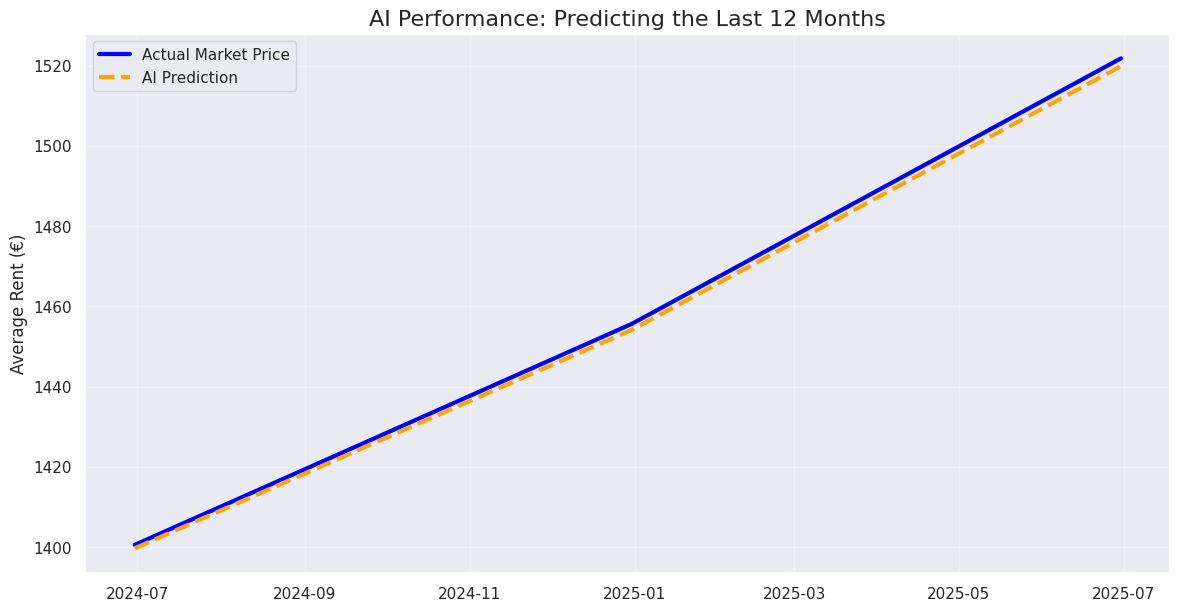

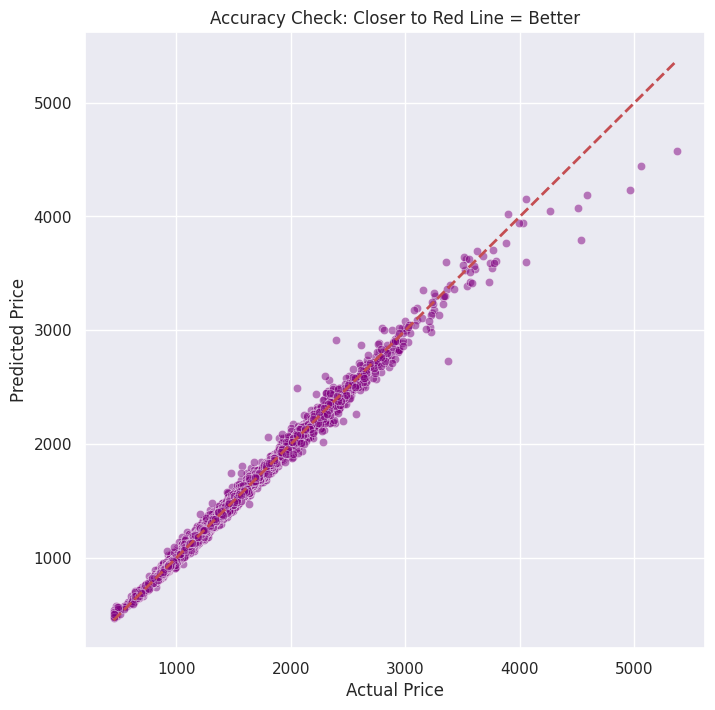

In [61]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.dates as mdates

print("--- 1. PREPARING THE MATRIX ---")

# Identify all categorical columns in df_ml that need encoding
categorical_cols_to_encode = df_ml.select_dtypes(include='object').columns.tolist()

# 1. Encoding all categorical columns (Text -> Numbers)
# We use One-Hot Encoding so the model knows 'Dublin' is different from 'Mayo', 'Apartment' from 'House', etc.
df_final = pd.get_dummies(df_ml, columns=categorical_cols_to_encode, drop_first=True)

# 2. Defining Target & Features
# We want to predict 'rent_euro' using History
target = 'rent_euro'
# Excluding 'Date', and 'Is_Dublin' from features, as well as the original 'half_year' that was causing issues
features = [col for col in df_final.columns if col != target and 'Date' not in col and 'Is_Dublin' not in col and col != 'half_year']

print(f"Training with {len(features)} features (Lags, Rolling Means, County Flags...)")

# 3. TIME-BASED SPLIT (Crucial for Time Series)
# Train on 2020-2023. Test on 2024+ (The "Future")
# We are assuming the data is sorted by Date from earlier steps
split_date = df_final['Date'].max() - pd.DateOffset(months=12) # Test on last 12 months
print(f"Splitting Data. Training before: {split_date.date()}")

train = df_final[df_final['Date'] < split_date]
test = df_final[df_final['Date'] >= split_date]

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]
dates_test = test['Date']

print(f"Train Size: {X_train.shape[0]} samples | Test Size: {X_test.shape[0]} samples")


print("\n--- 2. TRAINING THE AI (GRADIENT BOOSTING) ---")
# Using Gradient Boosting (stronger than Random Forest for trends)
model = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)
model.fit(X_train, y_train)

# Predict
predictions = model.predict(X_test)


print("\n--- 3. EVALUATION REPORT ---")
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)
error_margin = (mae / y_test.mean()) * 100

print(f"💰 Average Prediction Error: €{mae:,.2f}")
print(f"🎯 Model Accuracy (R2):      {r2*100:.1f}%")
print(f"⚠️ Error Margin:             {error_margin:.1f}% (Lower is better)")


print("\n--- 4. VISUALIZING REALITY VS AI ---")
# Let's plot the predictions for Dublin vs Countryside to see if it works

plt.figure(figsize=(14, 7))

# Plot subset (First 100 test points for clarity) or aggregate
results = pd.DataFrame({'Date': dates_test, 'Actual': y_test, 'Predicted': predictions})

# Plotting the Average Actual vs Average Predicted over time (to smooth out noise)
daily_avg = results.groupby('Date').mean()

plt.plot(daily_avg.index, daily_avg['Actual'], label='Actual Market Price', color='blue', linewidth=3)
plt.plot(daily_avg.index, daily_avg['Predicted'], label='AI Prediction', color='orange', linestyle='--', linewidth=3)

plt.title('AI Performance: Predicting the Last 12 Months', fontsize=16)
plt.ylabel('Average Rent (€)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.show()

# Scatter Plot (Perfect Prediction = Diagonal Line)
plt.figure(figsize=(8, 8))
sns.scatterplot(x=y_test, y=predictions, alpha=0.5, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Diagonal
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Accuracy Check: Closer to Red Line = Better')
plt.show()

# Thank You